# **Loan Approval Explainability Analysis**


- Part 1: Data Preparation
- Part 2: Model Building
- Part 3: SHAP Explanations (Begin Assignment 5.1)

## **Part 1: Data Preparation**

In [2]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AAI-531/module5/loan_approval_biased.csv')



# data exploration
df.info()  # Check for missing values and data types
print(df.head(20))
df.describe()

# Print the counts
#Count the number of males and females in the dataset
gender_counts = df['Gender'].value_counts()

# Print the counts
print("\nCounts of each gender in the dataset")
print(gender_counts)

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    int64  
 3   Dependents         614 non-null    int64  
 4   Education          614 non-null    int64  
 5   Self_Employed      614 non-null    int64  
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    int64  
 9   Loan_Amount_Term   614 non-null    int64  
 10  Credit_History     614 non-null    int64  
 11  Property_Area      614 non-null    int64  
 12  Loan_Status        614 non-null    object 
dtypes: float64(1), int64(9), object(3)
memory usage: 62.5+ KB
     Loan_ID  Gender  Married  Dependents  Education  Self_Employed  \
0   LP002317   

### **Prepare Data for Logistic Regression:**

- Convert Loan_Status to binary (1 for Y, 0 for N)
- Convert Gender column to binary (1 for Male, 0 for Female)
- Define the preprocessor with OneHotEncoder for remaining categorical features


In [3]:
# Convert Loan_Status to binary (1 for Y, 0 for N)
df['Loan_Status'] = df['Loan_Status'].apply(lambda x: 1 if x == 'Y' else 0)

# Define categorical and numerical columns
categorical_columns = ['Married', 'Dependents', 'Self_Employed', 'Property_Area','Gender']
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

# Convert Gender column to binary (1 for Male, 0 for Female)
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

# Define the preprocessor with OneHotEncoder for remaining categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns),
        ('num', StandardScaler(), numerical_columns)
    ])

# Split the data into features and target
X = df.drop(columns=['Loan_ID', 'Loan_Status'])
y = df['Loan_Status']

# Apply the preprocessor on the full dataset
X_transformed = preprocessor.fit_transform(X)

# Convert the transformed data back into a df
transformed_feature_names = preprocessor.get_feature_names_out()
X_transformed_df = pd.DataFrame(X_transformed, columns=transformed_feature_names)

# Display the transformed data
print(X_transformed_df.head())



   cat__Married_0  cat__Married_1  cat__Dependents_0  cat__Dependents_1  \
0             0.0             1.0                0.0                0.0   
1             0.0             1.0                1.0                0.0   
2             0.0             1.0                0.0                0.0   
3             0.0             1.0                1.0                0.0   
4             1.0             0.0                0.0                1.0   

   cat__Dependents_2  cat__Dependents_3  cat__Self_Employed_0  \
0                0.0                1.0                   1.0   
1                0.0                0.0                   1.0   
2                0.0                1.0                   1.0   
3                0.0                0.0                   0.0   
4                0.0                0.0                   1.0   

   cat__Self_Employed_1  cat__Property_Area_0  cat__Property_Area_1  \
0                   0.0                   1.0                   0.0   
1               

In [4]:
#  Count the number of approved loans for each gender
# Filter for approved loans
approved_loans = df[df['Loan_Status'] == 1]

gender_approval_counts = approved_loans['Gender'].value_counts()

print(gender_approval_counts)

Gender
1    217
0      3
Name: count, dtype: int64


## **Part 2: Model Building**

In [5]:
# stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit the preprocessor on training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Create the pipeline with a logistic regression model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=10000))
])

# Fit the model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['Married', 'Dependents',
                                                   'Self_Employed',
                                                   'Property_Area', 'Gender']),
                                                 ('num', StandardScaler(),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'Loan_Amount_Term',
                                                   'Credit_History'])])),
                ('classifier', LogisticRegression(max_iter=10000))])

In [6]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9106
Precision: 0.9231
Recall: 0.8182
F1 Score: 0.8675


**Expected Output:**

- Logistic regression model should fit to the training data successfully.


*********

# **Begin Assignment 5.1**

## In this exercise, you will analyze the loan approval dataset and utilize SHAP to understand feature contributions to model predictions. The goal is to interpret how specific features affect decisions and reflect on the ethical implications of such models.


## **Part 3: SHAP Explanations**

(all output and responses should placed in 5.1 exercise document)

In [7]:
# Explaining model predictions using SHAP
# Take a sample of the training data for SHAP
X_sample = shap.sample(X_train, 100)

# Create the SHAP explainer
explainer = shap.Explainer(model.predict_proba, X_sample)

# Get SHAP values for the test set
shap_values = explainer(X_test)






PermutationExplainer explainer: 124it [00:25,  3.63it/s]


### **Question 1a. Use SHAP to understand how individual features contribute to the prediction for a specific data point with a force plot that visualizes the feature contributions for a particular class.**

#### <b> Instructions </b>
- Generate the <b> SHAP force plot </b> for the first data point in your test set using the SHAP values.
- The force plot should explain how individual features contribute to pushing the model's prediction towards or away from <b> class 1 </b>.
- Make sure to use SHAP values corresponding to class 1 for the <b> first data point </b> in the test set.


In [8]:
import shap

# Step 1: Extract the trained classifier
logistic_model = model.named_steps['classifier']

# Step 2: Get preprocessed test data as dense array
X_test_transformed = model.named_steps['preprocessor'].transform(X_test)
X_test_df = pd.DataFrame(
    X_test_transformed.toarray() if hasattr(X_test_transformed, "toarray") else X_test_transformed,
    columns=model.named_steps['preprocessor'].get_feature_names_out()
)

# Step 3: Initialize SHAP Explainer (model-agnostic linear version)
explainer = shap.Explainer(logistic_model, X_test_df)

# Step 4: Compute SHAP values for the first sample
sample_idx = 0
shap_values = explainer(X_test_df.iloc[[sample_idx]])

# Step 5: Generate the SHAP force plot for class 1
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values.values[0],           # SHAP values for this sample
    features=X_test_df.iloc[sample_idx],
    feature_names=X_test_df.columns
)


In [12]:
#  class 0

# Find indices where Loan_Status is 0
class_0_indices = df[df['Loan_Status'] == 0].index

# Print the indices
print("Indices of class 0:")
class_0_indices


Indices of class 0:


Index([ 17,  23,  37,  45,  48,  49,  50,  51,  52,  54,
       ...
       603, 604, 605, 606, 608, 609, 610, 611, 612, 613],
      dtype='int64', length=394)

In [81]:


# Find indices where Loan_Status is 1
class_1_indices = df[df['Loan_Status'] == 1].index

# Print the indices
print("Indices of class 1:")
class_1_indices


Indices of class 1:


Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       498, 530, 548, 556, 562, 581, 588, 592, 599, 607],
      dtype='int64', length=220)

In [28]:
#create plot for class 0


# Find indices where Loan_Status is 0 in the original DataFrame
class_0_indices = df[df['Loan_Status'] == 0].index

# Select the first index of class 0 in the test set
if not class_0_indices.empty:
    first_class_0_index_test = class_0_indices[0]

    # Check if the index exists in X_test_df
    if first_class_0_index_test < len(X_test_df):
      # Step 4: Compute SHAP values for the first class 0 sample in the test set
      sample_idx = first_class_0_index_test
      shap_values_class_0 = explainer(X_test_df.iloc[[sample_idx]])

      # Step 5: Generate the SHAP force plot for class 1 for the class 0 sample
      shap.initjs()
      shap.force_plot(
          base_value=explainer.expected_value,  # Use expected_value directly as it's a scalar
          shap_values=shap_values_class_0.values[0],  # SHAP values for the sample
          features=X_test_df.iloc[sample_idx],
          feature_names=X_test_df.columns
      )
    else:
      print("Index out of bounds for X_test_df")
else:
    print("No instances of class 0 found.")

The SHAP force plot explains why the model predicted a very low probability of loan approval for this specific applicant. The model’s output (f(x) = -7.08) is much lower than the base value (-0.65), indicating a strong prediction for Class 0 (loan rejection). Several features contributed to pulling the prediction downward, including the applicant being male (cat__Gender_0 = 1), having a low income (num__ApplicantIncome = -0.5482), and residing in a certain property area (cat__Property_Area_2 = 1). The only factor that slightly pushed the prediction upward was the applicant’s credit history (num__Credit_History = 0.4705). Overall, the combined impact of the features resulted in a prediction with less than 0.1% probability of loan approval.

### **Question 1b. Which features are pushing the prediction towards class 1? Which features are pushing the prediction away from class 1?**

In [65]:
# SHAP Bar plot
# Get SHAP values for sample 0
sample_idx = 0
shap_values_0 = shap_values.values[0]  # SHAP values for first sample
features_0 = X_test_df.iloc[sample_idx]

# Zip together feature names and their SHAP values
feature_impact = list(zip(X_test_df.columns, shap_values_0))

# Separate features by direction
toward_class1 = [(f, v) for f, v in feature_impact if v > 0]
away_from_class1 = [(f, v) for f, v in feature_impact if v < 0]

# Sort by absolute contribution
toward_class1 = sorted(toward_class1, key=lambda x: -abs(x[1]))
away_from_class1 = sorted(away_from_class1, key=lambda x: -abs(x[1]))

print(" Features pushing TOWARDS ----> class 1:")
for feat, val in toward_class1:
    print(f"{feat}: +{val:.4f}")

print("\n Features pushing AWAY -----> class 1:")
for feat, val in away_from_class1:
    print(f"{feat}: {val:.4f}")


 Features pushing TOWARDS ----> class 1:
num__Credit_History: +0.3552
cat__Dependents_0: +0.0733
num__CoapplicantIncome: +0.0681
cat__Dependents_1: +0.0573
cat__Dependents_3: +0.0204

 Features pushing AWAY -----> class 1:
cat__Gender_1: -2.1069
cat__Gender_0: -2.1058
num__ApplicantIncome: -1.8854
cat__Property_Area_2: -0.4069
cat__Property_Area_1: -0.1174
cat__Property_Area_0: -0.0828
cat__Married_1: -0.0724
cat__Married_0: -0.0715
cat__Dependents_2: -0.0548
num__LoanAmount: -0.0346
num__Loan_Amount_Term: -0.0303
cat__Self_Employed_1: -0.0194
cat__Self_Employed_0: -0.0192


In [66]:
for feat, val in toward_class1:
    print(f"{feat} (value: {features_0[feat]:.4f}): +{val:.4f}")

num__Credit_History (value: 0.4705): +0.3552
cat__Dependents_0 (value: 1.0000): +0.0733
num__CoapplicantIncome (value: -0.5357): +0.0681
cat__Dependents_1 (value: 0.0000): +0.0573
cat__Dependents_3 (value: 0.0000): +0.0204


In [67]:


# Find indices where Loan_Status is 0 in the original DataFrame
class_0_indices = df[df['Loan_Status'] == 0].index

print("Indices of class 0:")
class_0_indices


Indices of class 0:


Index([ 17,  23,  37,  45,  48,  49,  50,  51,  52,  54,
       ...
       603, 604, 605, 606, 608, 609, 610, 611, 612, 613],
      dtype='int64', length=394)

In [69]:


# To answer for a different sample,  modify sample_idx:
sample_idx = 0 # Change this to analyze a different sample

# Get SHAP values for the new sample
shap_values_new = explainer(X_test_df.iloc[[sample_idx]])

# Rest of the code remains the same, just replace shap_values with shap_values_new
# and feature_0 with features_new (as shown below)

shap_values_new_sample = shap_values_new.values[0]  # SHAP values for the new sample
features_new = X_test_df.iloc[sample_idx]  # Features of the new sample

feature_impact_new = list(zip(X_test_df.columns, shap_values_new_sample))

toward_class0_new = [(f, v) for f, v in feature_impact_new if v > 0]
away_from_class0_new = [(f, v) for f, v in feature_impact_new if v < 0]

toward_class0_new = sorted(toward_class0_new, key=lambda x: -abs(x[1]))
away_from_class0_new = sorted(away_from_class0_new, key=lambda x: -abs(x[1]))

print("\nFeatures pushing TOWARDS ----> class 0 (for sample", sample_idx, "):")
for feat, val in toward_class0_new:
    print(f"{feat} (value: {features_new[feat]:.4f}): +{val:.4f}")

print("\nFeatures pushing AWAY -----> class 0 (for sample", sample_idx, "):")
for feat, val in away_from_class0_new:
    print(f"{feat} (value: {features_new[feat]:.4f}): {val:.4f}")



Features pushing TOWARDS ----> class 0 (for sample 0 ):
num__Credit_History (value: 0.4705): +0.3552
cat__Dependents_0 (value: 1.0000): +0.0733
num__CoapplicantIncome (value: -0.5357): +0.0681
cat__Dependents_1 (value: 0.0000): +0.0573
cat__Dependents_3 (value: 0.0000): +0.0204

Features pushing AWAY -----> class 0 (for sample 0 ):
cat__Gender_1 (value: 0.0000): -2.1069
cat__Gender_0 (value: 1.0000): -2.1058
num__ApplicantIncome (value: -0.5482): -1.8854
cat__Property_Area_2 (value: 1.0000): -0.4069
cat__Property_Area_1 (value: 0.0000): -0.1174
cat__Property_Area_0 (value: 0.0000): -0.0828
cat__Married_1 (value: 0.0000): -0.0724
cat__Married_0 (value: 1.0000): -0.0715
cat__Dependents_2 (value: 0.0000): -0.0548
num__LoanAmount (value: -0.8952): -0.0346
num__Loan_Amount_Term (value: 0.3274): -0.0303
cat__Self_Employed_1 (value: 0.0000): -0.0194
cat__Self_Employed_0 (value: 1.0000): -0.0192


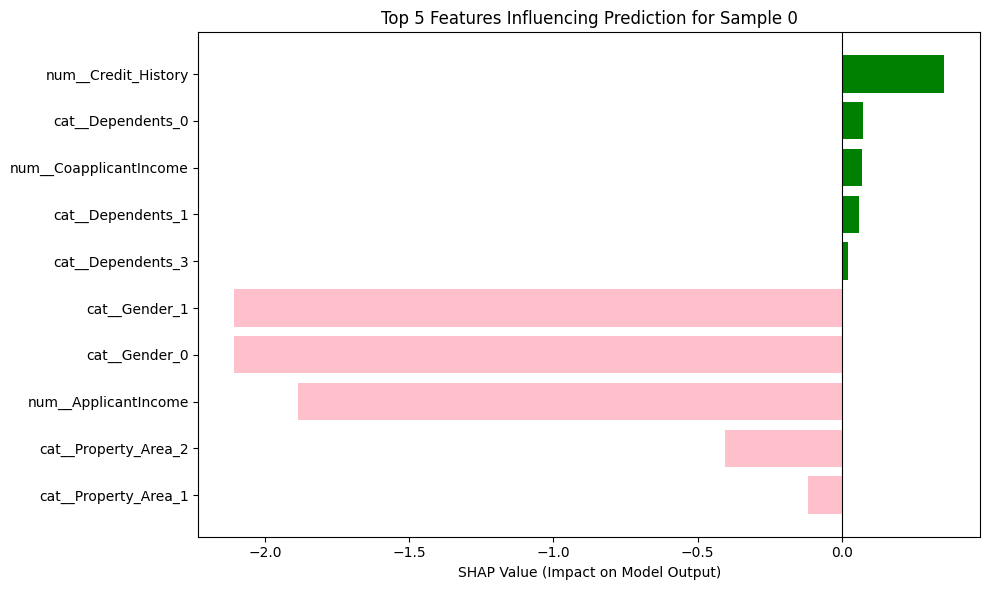

In [70]:
import matplotlib.pyplot as plt

# Number of top features to display from each group
top_n = 5

# Combine top contributors from both directions
top_toward = toward_class1[:top_n]
top_away = away_from_class1[:top_n]

# Combine and prepare for plotting
top_features = top_toward + top_away
features, values = zip(*top_features)

# Set colors: blue for positive (towards class 1), red for negative (away from class 1)
colors = ['green' if v > 0 else 'pink' for v in values]

# Horizontal bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(features, values, color=colors)
plt.axvline(0, color='black', linewidth=0.8)
plt.title(f"Top {top_n} Features Influencing Prediction for Sample {sample_idx}")
plt.xlabel("SHAP Value (Impact on Model Output)")
plt.gca().invert_yaxis()  # Most important at the top
plt.tight_layout()
plt.show()


In [64]:
print(model.classes_)

[0 1]


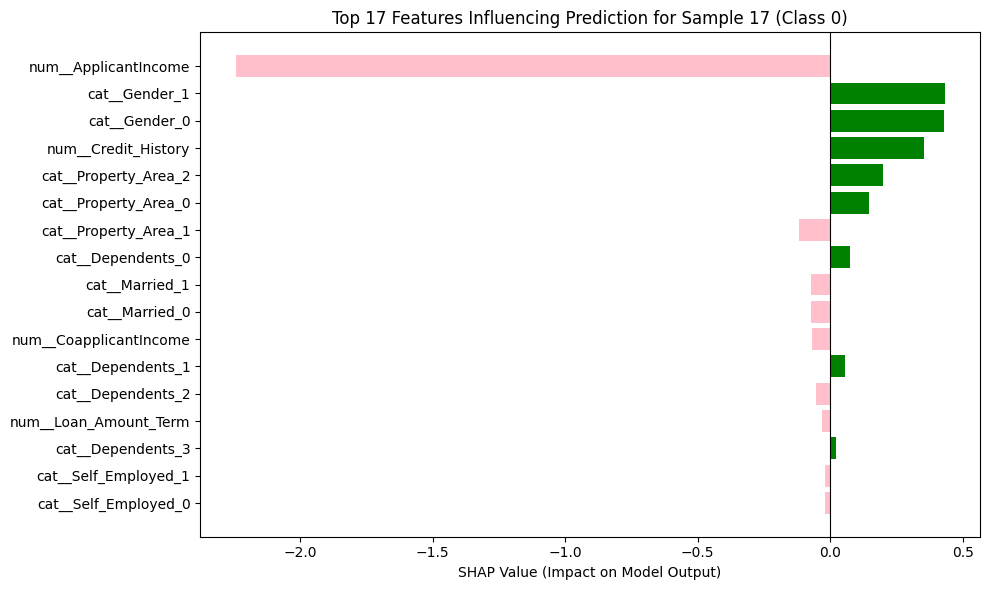

In [76]:
#Create a bar plot that displays the SHAP values (feature contributions) for the 17 data point and SHAP values for class 0. The bar plot will show how much each feature contributes to the model's prediction for class 1, with the features ranked by their contribution.)

# Assuming you have already executed the provided code and have the necessary variables defined.

import matplotlib.pyplot as plt

# Number of top features to display
top_n = 17

# Get SHAP values for the 17th data point (index 16) and class 0
sample_idx = 16  # Index of the 17th data point
shap_values_sample = explainer(X_test_df.iloc[[sample_idx]])
shap_values_17th_point_class_0 = shap_values_sample.values[0]

# Zip together feature names and their SHAP values for the selected data point
feature_impact_17th_point = list(zip(X_test_df.columns, shap_values_17th_point_class_0))


# Sort features by their absolute SHAP values to show the most influential ones
feature_impact_17th_point = sorted(feature_impact_17th_point, key=lambda x: -abs(x[1]))

# Select the top_n features
top_features_17th_point = feature_impact_17th_point[:top_n]

# Separate features and values for plotting
features, values = zip(*top_features_17th_point)

# Set colors: blue for positive (towards class 1), red for negative (away from class 1)
colors = ['green' if v > 0 else 'pink' for v in values]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(features, values, color=colors)
plt.axvline(0, color='black', linewidth=0.8)
plt.title(f"Top {top_n} Features Influencing Prediction for Sample {sample_idx+1} (Class 0)")
plt.xlabel("SHAP Value (Impact on Model Output)")
plt.gca().invert_yaxis()  # Most important at the top
plt.tight_layout()
plt.show()


### **Question 2a. Create a bar plot that displays the SHAP values (feature contributions) for the second data point and SHAP values for class 1. The bar plot will show how much each feature contributes to the model's prediction for class 1, with the features ranked by their contribution.)**

In [79]:
shap_values = explainer(X_test_df)
shap_values_class1 = shap_values[1]
print(shap_values_class1)

.values =
array([ 0.03850128,  0.0389928 , -0.10122735, -0.21572494, -0.05481531,
        0.02041158,  0.15541374,  0.1566636 , -0.08278382,  0.26137208,
        0.20042578,  0.43129893,  0.43153767, -1.36097866, -0.03221924,
        0.00296839, -0.03027259,  0.35523812])

.base_values =
np.float64(-0.6496256075201923)

.data =
array([ 0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        , -0.35568891,  0.14395724,
        0.06686656,  0.32739358,  0.47052421])


In [80]:
shap_values = explainer(X_test_df)
shap_values_class0 = shap_values[0]
print(shap_values_class0)

.values =
array([-0.07150237, -0.07241519,  0.07330257,  0.0573446 , -0.05481531,
        0.02041158, -0.01920844, -0.01936292, -0.08278382, -0.11742804,
       -0.40692507, -2.1057536 , -2.1069192 , -1.88539377,  0.06811449,
       -0.03458116, -0.03027259,  0.35523812])

.base_values =
np.float64(-0.6496256075201923)

.data =
array([ 1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  1.        ,  0.        , -0.54818842, -0.53569307,
       -0.89519107,  0.32739358,  0.47052421])


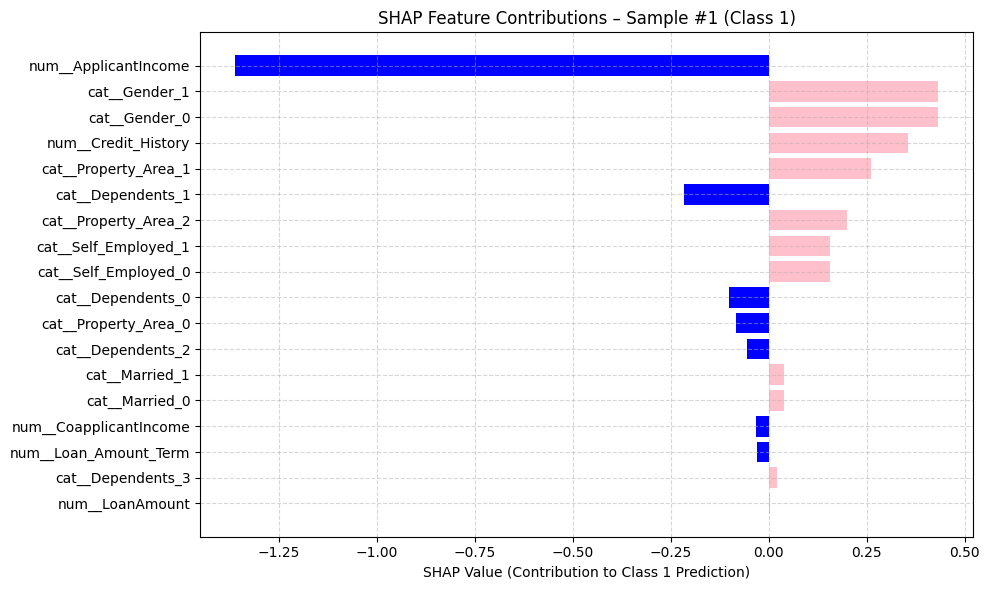

In [71]:
# Get SHAP values for second data point (index 1)
sample_idx = 1
shap_values_1 = explainer(X_test_df.iloc[[sample_idx]]).values[0]
features_1 = X_test_df.iloc[sample_idx]

# Create DataFrame of SHAP values
shap_df = pd.DataFrame({
    'Feature': X_test_df.columns,
    'SHAP Value': shap_values_1
})

# Sort by absolute SHAP value (importance)
shap_df_sorted = shap_df.reindex(shap_df['SHAP Value'].abs().sort_values(ascending=False).index)

# Plot bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
colors = ['pink' if val > 0 else 'blue' for val in shap_df_sorted['SHAP Value']]
plt.barh(shap_df_sorted['Feature'], shap_df_sorted['SHAP Value'], color=colors)
plt.xlabel("SHAP Value (Contribution to Class 1 Prediction)")
plt.title("SHAP Feature Contributions – Sample #1 (Class 1)")
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### **Question 2b. Which feature had the greatest influence on the prediction for this data point? Were most features pushing the prediction toward or away from class 1? Are there any surprising variables that are influencing the prediction?**

In [72]:
# From shap_df_sorted created in Question 2a
top_feature = shap_df_sorted.iloc[0]
top_direction = "toward" if top_feature["SHAP Value"] > 0 else "away from"
print(f" The feature with the greatest influence is: {top_feature['Feature']}")
print(f" It is pushing the prediction {top_direction} class 1.")

# Count feature directions
num_toward = (shap_df_sorted["SHAP Value"] > 0).sum()
num_away = (shap_df_sorted["SHAP Value"] < 0).sum()

print(f"\n Features pushing toward class 1: {num_toward}")
print(f"Features pushing away from class 1: {num_away}")

# Optional: Identify potential surprises
print("\n Surprising features (e.g., non-intuitive or weak predictors with high impact):")
threshold = shap_df_sorted["SHAP Value"].abs().max() * 0.5  # Adjust as needed
for i, row in shap_df_sorted.iterrows():
    if abs(row["SHAP Value"]) > threshold and "LoanAmount" not in row["Feature"] and "Credit_History" not in row["Feature"]:
        print(f" - {row['Feature']} with SHAP value {row['SHAP Value']:.4f}")


 The feature with the greatest influence is: num__ApplicantIncome
 It is pushing the prediction away from class 1.

 Features pushing toward class 1: 11
Features pushing away from class 1: 7

 Surprising features (e.g., non-intuitive or weak predictors with high impact):
 - num__ApplicantIncome with SHAP value -1.3610


In [73]:
# num__ApplicantIncome  - why it is surprising

# Analyze the 'num__ApplicantIncome' feature
applicant_income_impact = shap_df_sorted[shap_df_sorted['Feature'] == 'num__ApplicantIncome']

if not applicant_income_impact.empty:
    impact_value = applicant_income_impact['SHAP Value'].iloc[0]
    print(f"\nImpact of Applicant Income on the prediction for sample {sample_idx}: {impact_value:.4f}")

    if abs(impact_value) > 0.2 : # Define your threshold for "surprising"
        print("'num__ApplicantIncome' has a relatively high impact on the prediction. This may be surprising depending on the other features in the model and the specific context of the dataset.")

    #Further analysis can be done here to understand why it's surprising based on the other features and the specific prediction
else:
    print(" Applicant Income is not found in SHAP analysis.")



Impact of Applicant Income on the prediction for sample 1: -1.3610
'num__ApplicantIncome' has a relatively high impact on the prediction. This may be surprising depending on the other features in the model and the specific context of the dataset.


### **Question 3a.Create a beeswarm plot that visualizes the global importance of features for class 1 (positive class) across all data points. You will use this plot to identify which features consistently influence the model's prediction.**

#### **Instructions**
The beeswarm plot should display the SHAP values for <b> class 1</b> across all data points in the test set.

   Note: Features will be sorted by their importance, with the most influential features appearing at the top.


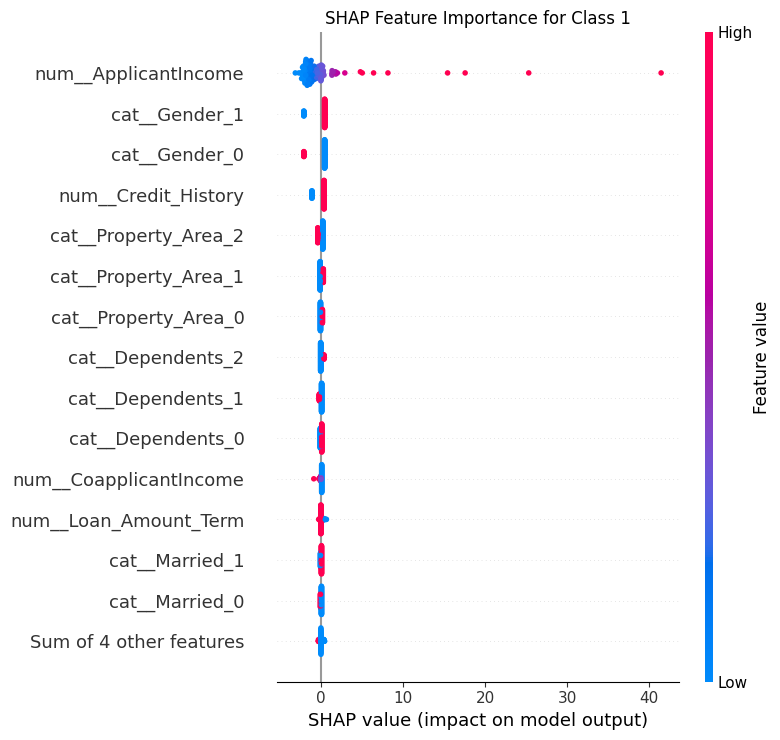

In [74]:
# Beeswarm plot
# Compute SHAP values for all test samples
shap_values_all = explainer(X_test_df)
import matplotlib.pyplot as plt
import shap

# Create beeswarm plot
shap.plots.beeswarm(shap_values_all, max_display=15, show=False)
plt.title("SHAP Feature Importance for Class 1")
plt.tight_layout()
plt.show()





This SHAP summary plot shows which features impact the model’s predictions the most across all samples. Each dot is a sample, positioned based on how much that feature pushed the prediction (SHAP value). Red dots represent high feature values, blue are low. Features like num__ApplicantIncome have the highest overall influence. Dots far from zero indicate strong impact, while clusters near zero suggest weaker influence.

### **Question 3b. Which feature appears to be the most important across all data points? Are there any features that have a mixed effect (i.e. pushing predictions towards class 1 and other times pushing them away?) What could cause this variability? How do the color of the dots help you interpret the relationship between the feature value and the prediction? Are there any notable findings?**

The SHAP summary plot shows that num__ApplicantIncome is the most important feature influencing predictions across all data points, with a wide range of SHAP values indicating strong impact. Interestingly, this feature has a mixed effect—in many cases, high income (shown in red) pushes predictions toward Class 1 (e.g., approval), but in other instances, it has little or even negative influence. This variability likely arises from interactions with other features, such as credit history or loan amount. The color gradient of the dots helps interpret how low (blue) or high (red) feature values relate to the prediction, revealing patterns and exceptions. Overall, while some features consistently support predictions in one direction, others like applicant income show context-dependent behavior, highlighting the complexity of the model’s decision-making.

Interactions with other features
E.g., a high LoanAmount might hurt approval chances unless Credit_History is perfect.
Non-linear relationships
Logistic models + one-hot encoding can still create complex decision boundaries.
Different applicant profiles
A high income might help a single borrower but hurt when co-applicant income is zero.

## **Part 4: Ethical Reflection**


As you explored the SHAP plots, you were able to see how individual featuers contribute to a model's predictions, increasing transparency. However, even with these interpretability tools, there are broader ethical concerns regarding bias and transparency in machine learning systems.

Machine learning models, particularly those used in high-stakes areas like healthcare, finance, and criminal justice, can inadvertently reinforce societal biases present in the training data (e.g., based on race, gender, income). While tools like SHAP provide insights into how models make decisions, they do not prevent biased outcomes.





**Question 1: How can explainability tools such as SHAP help identify bias in machine learning models?**


SHAP (and similar explainability tools) can help identify bias by:

Explainability tools like SHAP enhance transparency by revealing how individual features influence model predictions. Although SHAP doesn’t eliminate bias, it plays a crucial role in uncovering it. By examining SHAP values, we can identify when sensitive attributes such as gender, race, or income are having an undue influence on predictions. For example, if a feature like Gender consistently contributes significantly to model outputs, it may indicate potential bias.
SHAP also allows for group-level analysis, helping to detect disparities in how features affect different populations. This can highlight unfair treatment or unequal access to outcomes, especially in high-stakes areas like healthcare or finance. Additionally, SHAP supports fairness auditing by enabling comparisons across subgroups, helping practitioners spot patterns that would otherwise be hidden in a black-box model.
While SHAP can help identify sources of bias and guide mitigation strategies—such as re-engineering features or refining training data—it must be used alongside broader ethical practices. SHAP explains what the model is doing, but it does not determine whether the model’s use of features is fair or appropriate. Therefore, SHAP should be part of a comprehensive approach to fairness that includes ethical guidelines, bias audits, and careful data governance.


**Question 2: How does explainability contribute to transparency in machine learning systems?**


Explainability tools like SHAP enhance transparency by making complex machine learning models more interpretable, especially for stakeholders such as users, auditors, and regulators. SHAP clarifies the “why” behind each prediction by showing which features influenced the outcome and to what extent—supporting trust, accountability, and informed decision-making in sensitive domains like finance, healthcare, and criminal justice. It also makes models auditable by providing a shared framework for assessing fairness and ethics, enabling data scientists, ethicists, and compliance teams to evaluate and document model behavior. This is particularly valuable in regulated industries where organizations must justify decisions, demonstrate that processes are fair, and show that any bias was unintentional. Moreover, SHAP empowers non-technical stakeholders—such as customers or loan officers—by helping them understand the key drivers behind automated decisions. Ultimately, SHAP supports ethical AI by identifying potential biases, increasing transparency, and enabling meaningful human oversight through auditing, debugging, and fairness-focused interventions.